In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16,10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

![CRISP_DM](Crisp_DM_Tasks.png)

## Data load

In [32]:
# try to parse the dates right at the beginning
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('C:/ProgramData/Anaconda3/eps_covid19/data/processed/COVID_small_sync_timeline_table.csv',sep=';')
df_analyse.sort_values('date',ascending=True).head()

,doubling every day,doubling every two days,doubling every 4 days,doubling every 10 days,Albania,India,Italy,Germany,US,date
0,100.0,100.000000,100.000000,100.000000,104.0,102.0,155.0,130.0,103.0,0
1,200.0,141.421356,118.920712,107.177346,123.0,113.0,229.0,159.0,172.0,1
2,400.0,200.000000,141.421356,114.869835,146.0,119.0,322.0,196.0,215.0,2
3,800.0,282.842712,168.179283,123.114441,174.0,142.0,453.0,262.0,337.0,3
4,1600.0,400.000000,200.000000,131.950791,186.0,156.0,655.0,482.0,450.0,4


# Helper functions

In [33]:
def quick_plot(x_in, df_input, y_scale='log', slider=False):
    
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    
    fig = go.Figure()
    
    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                            x=x_in,
                            y=df_input[each],
                            mode='markers+lines',
                            opacity=0.8,
                            line_width=2,
                            marker_size=4,
                            name=each
                            )
                 )

## defines the overall layout properties
    fig.update_layout(title='Corona infection rate (slope) of different countries',autosize=True,
        width=1024, #1280 or 1920/
        height=768, #720 or 1080
        font=dict(
            family="PT Sans, monospace",
            size=12,
            color="#7f7f7f"
            ),
        xaxis_title="Time in days",
        yaxis_title="Confirmed infected people (source Johns Hopkins csse, log-scale)",
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                    nticks=20,
                    tickfont=dict(size=14,color="#7f7f7f")
                    )
    
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()

In [34]:
quick_plot(df_analyse.date,
          df_analyse.iloc[:,4:-1],
          y_scale='log',
          slider=True)

## Fitting a polynomial curve

In [35]:
# check that all data is available

df_poly_check= df_analyse.iloc[0:130,4:-1]
df_poly_check.tail()

,Albania,India,Italy,Germany,US
125,4763.0,1039084.0,240136.0,197198.0,2996098.0
126,4880.0,1077781.0,240310.0,197523.0,3054699.0
127,4997.0,1118206.0,240436.0,198064.0,3117946.0
128,5105.0,1155338.0,240578.0,198343.0,3185737.0
129,5197.0,1193078.0,240760.0,198699.0,3245925.0


In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [37]:
y=df_poly_check[['Albania','India','Italy','Germany']].unstack().sort_index(axis=0,level=1)

In [38]:
y.tail()

Germany  128     198343.0
Albania  129       5197.0
India    129    1193078.0
Italy    129     240760.0
Germany  129     198699.0
dtype: float64

In [39]:
test_points=100
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [40]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

In [41]:
%matplotlib inline
import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)}) # plot formatting, prepare for subplot

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

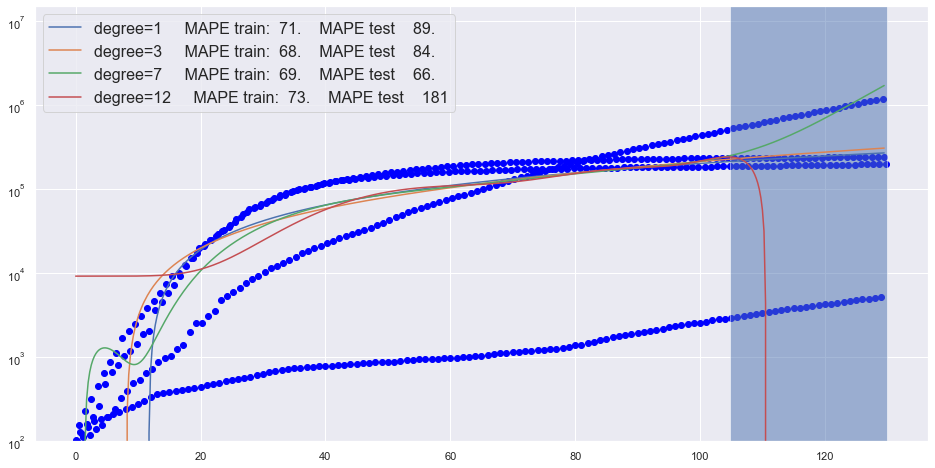

In [43]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,12]:
    y_hat_insample = PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)

    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insample, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                     '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insample, y_train))[0:3]
                     +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]                                               )

ax1.set_ylim(100, 15000000)
ax1.set_yscale('log')
ax1.legend(loc='best',
           prop={'size': 16});

## Regression Metrics source: Wikipedia

### Mean Absolute Error

mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in [[statistics]],

for example in trend estimation, also used as a loss function for regression problems in machine learning. It usually expresses the accuracy as a ratio defined by the formula:

$
\begin{align}
MAE =\frac{\sum_{i=1}^n |y_i - x_i|}{n} = \frac{\sum_{i=1}^n |e_i|}{n}
\end{align}
$

### Mean Absolute Percentage Error

mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in [[statistics]],

for example in trend estimation, also used as a loss function for regression problems in machine learning. It usually expresses the accuracy as a ratio defined by the formula:

$
\begin{align}
MAPE =\frac{1}{n} \sum_{i=1}^n \frac{|x_i - y_i|}{x_i}
\end{align}
$

### if the MAPE is 80, on average, the forecast is off by 80%

In [44]:
'''
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
'''

'\ndef mean_absolute_percentage_error(y_true, y_pred): \n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100\n'

### Symmetric mean absolute percentage error

Symmetric mean absolute percentage error (SMAPE''' or '''sMAPE)''' is an accuracy measure based on percentage (or relative) errors. It is usually defined{{Citation needed|reason=S. Makridakis didn't use following definition in his article ''Accuracy measures: theoretical and practical concerns,'' 1993.|date=May 2017}} as follows:

$
\begin{align}
SMAPE =\frac{100\%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}
\end{align}
$